In [4]:
# 보스턴 주택 가격 데이터셋

from tensorflow.keras.datasets import boston_housing

(train_data, train_targets), (test_data, test_targets) = boston_housing.load_data()

print("train_data.shape : ",train_data.shape, "test_data.shape : ",test_data.shape)

print("train_targets: ", train_targets[:10]) # 대략 1만 달러에서 5만 달러 사이 - 70년대라서 인플레이션에 영향을 받지 않았다.


train_data.shape :  (404, 13) test_data.shape :  (102, 13)
train_targets:  [15.2 42.3 50.  21.1 17.7 18.5 11.3 15.6 15.6 14.4]


In [5]:
# 데이터 정규화하기

mean = train_data.mean(axis=0) # 열
train_data -= mean # 평균을 빼기
std = train_data.std(axis = 0) # 표준편차
train_data /= std # 표준 편차로 나누기

test_data -= mean # 테스트 샘플도 똑같이 평균 빼기
test_data /= std # 표준 편차로 나누기


In [8]:
# 모델 정의
from tensorflow.keras import models,layers

def build_model(): #동일한 모델 여러 번 생성할 예정
    model = models.Sequential()
    model.add(layers.Dense(64, activation='relu',
                          input_shape=(train_data.shape[1],)))
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(1)) # 활성화 함수가 없다. 선형층이라고도 부른다.
    # 전형적인 스칼라 회귀(하나의 연속적인 값을 예측하는 회귀)를 위한 구성이다.
    # 활성화 함수를 사용시 제한된 값을 예측하므로 x
    model.compile(optimizer = 'rmsprop',
                loss='mse', metrics=['mae'])
    return model


In [22]:
# K-겹 검증

import numpy as np
k=4

num_val_samples = len(train_data) // k
num_epochs = 100
all_scores = []

for i in range(k):
    print('처리중인 폴드 #',i)
    val_data = train_data[i * num_val_samples : (i+1) * num_val_samples]
    val_targets = train_targets[i * num_val_samples : (i+1) * num_val_samples]
    
    partial_train_data = np.concatenate( # 훈련 데이터 준비 : 다른 분할 전체
        [train_data[:i * num_val_samples],
        train_data[(i+1) * num_val_samples:]],
        axis = 0
    )
    partial_train_targets = np.concatenate(
        [train_targets[:i * num_val_samples],
        train_targets[(i+1) * num_val_samples:]],
         axis = 0
    )
    
    model = build_model() # 케라스 모델 구성 컴파일 포함
    model.fit(partial_train_data, partial_train_targets,
             epochs = num_epochs, batch_size =1, verbose = 0) # 모델 훈련(vervose=0)과정이 출력되지 않는다.
    val_mse, val_mae = model.evaluate(val_data, val_targets, verbose=0)
    all_scores.append(val_mae)
    
print(all_scores)
print(np.mean(all_scores))


처리중인 폴드 # 0
처리중인 폴드 # 1
처리중인 폴드 # 2
처리중인 폴드 # 3


In [33]:
num_epochs = 500
all_mae_histories = []
for i in range(k):
    print('처리중인 폴드 #', i)
    val_data = train_data[i * num_val_samples: (i + 1) * num_val_samples]  #검증 데이터 준비: k번째 분할    val_targets = train_targets[i * num_val_samples: (i + 1) * num_val_samples]
    partial_train_data = np.concatenate(  # 훈련 데이터 준비: 다른 분할 전체
        [train_data[:i * num_val_samples],
         train_data[(i + 1) * num_val_samples:]],
        axis=0)
    partial_train_targets = np.concatenate(
        [train_targets[:i * num_val_samples],
         train_targets[(i + 1) * num_val_samples:]],
        axis=0)

model = build_model()  # 케라스 모델 구성(컴파일 포함)
history = model.fit(partial_train_data, partial_train_targets,  # 모델 훈련(verbose=0이므로 훈련 과정이 출력되지 않습니다.)
                    validation_data=(val_data, val_targets),
                    epochs=num_epochs, batch_size=1, verbose=0)
mae_history = history.history['mae']
all_mae_histories.append(mae_history)

처리중인 폴드 # 0
처리중인 폴드 # 1
처리중인 폴드 # 2
처리중인 폴드 # 3


In [34]:
# 평균 기록
average_mae_history = [
    np.mean([x[i] for x in all_mae_histories]) for i in range(num_epochs)]


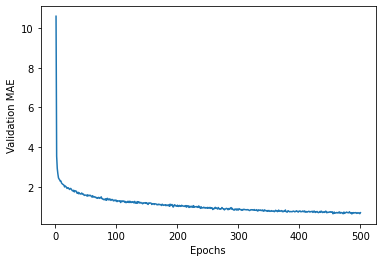

In [35]:
# 검증 점수 그래프

import matplotlib.pyplot as plt

plt.plot(range(1, len(average_mae_history) + 1), average_mae_history)

plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

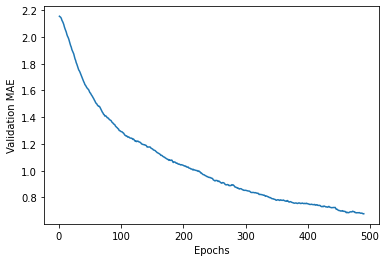

In [36]:
# 처음 10개 데이터 포인트 제외한 검증 점수 그리기

def smooth_curve(points, factor=0.9):
    smoothed_points = []
    for point in points:
        if smoothed_points:
            previous = smoothed_points[-1]
            smoothed_points.append(previous * factor + point * (1-factor))
        else:
            smoothed_points.append(point)
    return smoothed_points
    
smooth_mae_history = smooth_curve(average_mae_history[10:])

plt.plot(range(1, len(smooth_mae_history)+1), smooth_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()



In [40]:
# 최종 모델 훈련

model = build_model()
model.fit(train_data, train_targets,
         epochs = 80, batch_size = 16, verbose=0)

test_mse_score, test_mae_score = model.evaluate(test_data, test_targets)

print("test_mae_score : ",test_mae_score, "test mse_score : ", test_mse_score)


4/4 [==============================] - 0s 1ms/step - loss: 18.1897 - mae: 2.6273
test_mae_score :  2.6272621154785156 test mse_score :  18.189722061157227
